In [42]:
import glob
import os, sys
import inspect
currentdir = os.path.dirname(os.path.abspath(os.getcwd()))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, currentdir) 
os.path.abspath(os.getcwd())

import torch
import torch.nn as nn
import pandas
import numpy as np
import numpy.ma as ma
import pickle
import time

import proplot as pplt
import matplotlib.colors as mplcolors
import scipy.stats as st
import sklearn
import re 
from fractions import Fraction

from utils import *
from plotting_functions import *

In [3]:
Integrator = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])


Resetter = -100 * np.array([[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,1,0]])
b = 1000
ChoiceMaker = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,b],[0,0,0,b]])   #v1
# ChoiceMaker = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]) #v2

bias = np.array([0,0,-b,-b])

W_in = Integrator + Resetter + ChoiceMaker

W_hh = np.array([[1,0,0,0],[0,1,0,0],[1,-1,0,0],[-1,1,0,0]])     #v1
# W_hh = np.array([[1,0,0,0],[0,1,0,0],[1,-1,-1,-1],[-1,1,-1,-1]]) #v2


W_out = np.array([[0,0,1,0],[0,0,0,1]])                      #v1
# W_out = np.array([[-1,-1,1,0],[-1,-1,0,1]])                  #v2


ouput_bias = np.array([0,0])

print("W_hh:", W_hh, "\n",
      "W_in:", W_in, "\n",
      "W_out:", W_out)

W_hh: [[ 1  0  0  0]
 [ 0  1  0  0]
 [ 1 -1  0  0]
 [-1  1  0  0]] 
 W_in: [[   1    0 -100    0]
 [   0    1 -100    0]
 [   0    0 -100 1000]
 [   0    0 -100 1000]] 
 W_out: [[0 0 1 0]
 [0 0 0 1]]


In [4]:
# Integrator = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1]]) #v3
# Resetter = -10000 * np.array([[0,0,1,0],[0,0,1,0],[0,0,1,0]])
# W_in = Integrator + Resetter

# bias = np.array([0,0,0])
# W_hh = np.array([[1,0,0],
#                  [0,1,0],
#                  [0,0,0]])     #v3
# b = 1000
# W_out_1 = 1*np.array([[0,0,b],[0,0,b]])                      #v3
# W_out_2 = 10*np.array([[1,-1,0],[-1,1,0]])
# W_out = W_out_1 + W_out_2
# ouput_bias = np.array([-b,-b])
# #W_in

In [7]:
# #v4: cue duration=1, target output duration=1
alpha = 1.
beta = 2

Integrator = np.array([[1,0,0,0],[0,1,0,0],[-1,-1,0,beta],[-1,-1,0,0]]) 
Resetter = -10000 * np.array([[0,0,1,0],[0,0,1,0],[0,0,1,0],[0,0,1,0]])
W_in = Integrator + Resetter

bias = np.array([0,0,-1,-1.])
W_hh = np.array([[1,0,0,0],[0,1,0,0],[0,0,alpha,0],[0,0,2,0]])     
W_out_1 = np.array([[0,0,0,b],[0,0,0,b]])                      
W_out_2 = 10*np.array([[1,-1,0,0],[-1,1,0,0]])
W_out = W_out_1 + W_out_2

b = 1000
ouput_bias = np.array([-b,-b])
print("W_hh:", W_hh, "\n",
      "W_in:", W_in, "\n",
      "W_out:", W_out)

W_hh: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 2. 0.]] 
 W_in: [[     1      0 -10000      0]
 [     0      1 -10000      0]
 [    -1     -1 -10000      2]
 [    -1     -1 -10000      0]] 
 W_out: [[  10  -10    0 1000]
 [ -10   10    0 1000]]


In [8]:
N_rec_perfect = W_hh.shape[0]
#embed perfect model into random network

#random network
N_rec = W_hh.shape[1] #20
# np.random.normal(loc=0.0, scale=1.0, size=(N_rec, N_rec))

exp_list = glob.glob(currentdir+"\\experiments\\poisson_clicks\\exp*51")#list experiment folders
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))
exp_path = exp_list[-1]
perfect_path = currentdir + "//experiments//poisson_clicks//perfect_model//"
with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)

training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path + '/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'
training_kwargs['N_in'] = 4
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu' #training_kwargs['device']
makedirs(perfect_path)

In [9]:
N_in = training_kwargs['N_in']
N_out = 2
rnn_model = RNNModel(N_in, N_out, N_rec, n_layers=1, transform_function='relu')

with torch.no_grad():
    rnn_model.rnn.all_weights[0][0][:] = torch.tensor(W_in, dtype=torch.float)
    rnn_model.rnn.all_weights[0][1][:] = torch.tensor(W_hh, dtype=torch.float)
        #biases of hidden neuron
    rnn_model.rnn.all_weights[0][2][:] =  torch.tensor(bias, dtype=torch.float)
    rnn_model.rnn.all_weights[0][3][:] =  torch.zeros((N_rec), dtype=torch.float)
        #fully connected layers
    rnn_model.fc.weight = nn.Parameter(torch.tensor(W_out, dtype=torch.float))
    rnn_model.fc.bias = nn.Parameter(torch.tensor(ouput_bias, dtype=torch.float)) 
    
torch.save(rnn_model.state_dict(), perfect_path + '/perfect_weights.pth')

rnn_model.to(device)
# python train_plot.py --N_in=4 --fixed_cue_onsetandduration=10,5,10,1  --coherence_list=30,20,10,5,2 --task=poisson_clicks --loss_function=bcewll  --model_type=rnn_cued --early_stopping_criterion_epochs=50 --max_epochs=250 --accuracy_goal=0.95 --scheduler=cosineannealing --verbosity=True --N_rec=4 --single_or_curriculum=curriculum --optimizer=adam --load_model=C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\perfect_model\perfect_weights.pth
# using output without end with --fixed_cue_onsetandduration=10,5,10,10000


# but trials with equal clicks make loss nonzero!!! this then decreases accuracy over time 

#embed perfect model into random network

RNNModel(
  (rnn): RNN(4, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=2, bias=True)
  (out_act): Sigmoid()
)

In [10]:


rnn_model.rnn.all_weights[0][1]

Parameter containing:
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 2., 0.]], requires_grad=True)

In [11]:
N_test_batch = 1000
training_kwargs['equal_clicks'] = ''
training_kwargs['target_withcue'] = False

training_kwargs['fixed_cue_onsetandduration'] = [20,1,20,1]
training_kwargs['model_type'] = 'rnn_cued'
training_kwargs['N_in'] = 4
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
test_x, y, output_mask, trial_params = pd.get_trial_batch() #generate self.N_batch trials

inputs = torch.tensor(test_x, dtype=torch.float).to(device)
hidden = torch.normal(0, training_kwargs['hidden_initial_variance'], (rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim)).to(device) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
yhat = rnn_model.out_act(rnn_model.fc(hidden_states)).cpu().detach().numpy()
hidden_states = hidden_states.cpu().detach().numpy()

accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(test_x, yhat, output_mask)
print("Accuracy:", accuracy)

Accuracy: 1.0


C:\Users\abel_\AppData\Local\Temp\ipykernel_16488\1828534248.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(hs, ax=ax, label='Click difference')


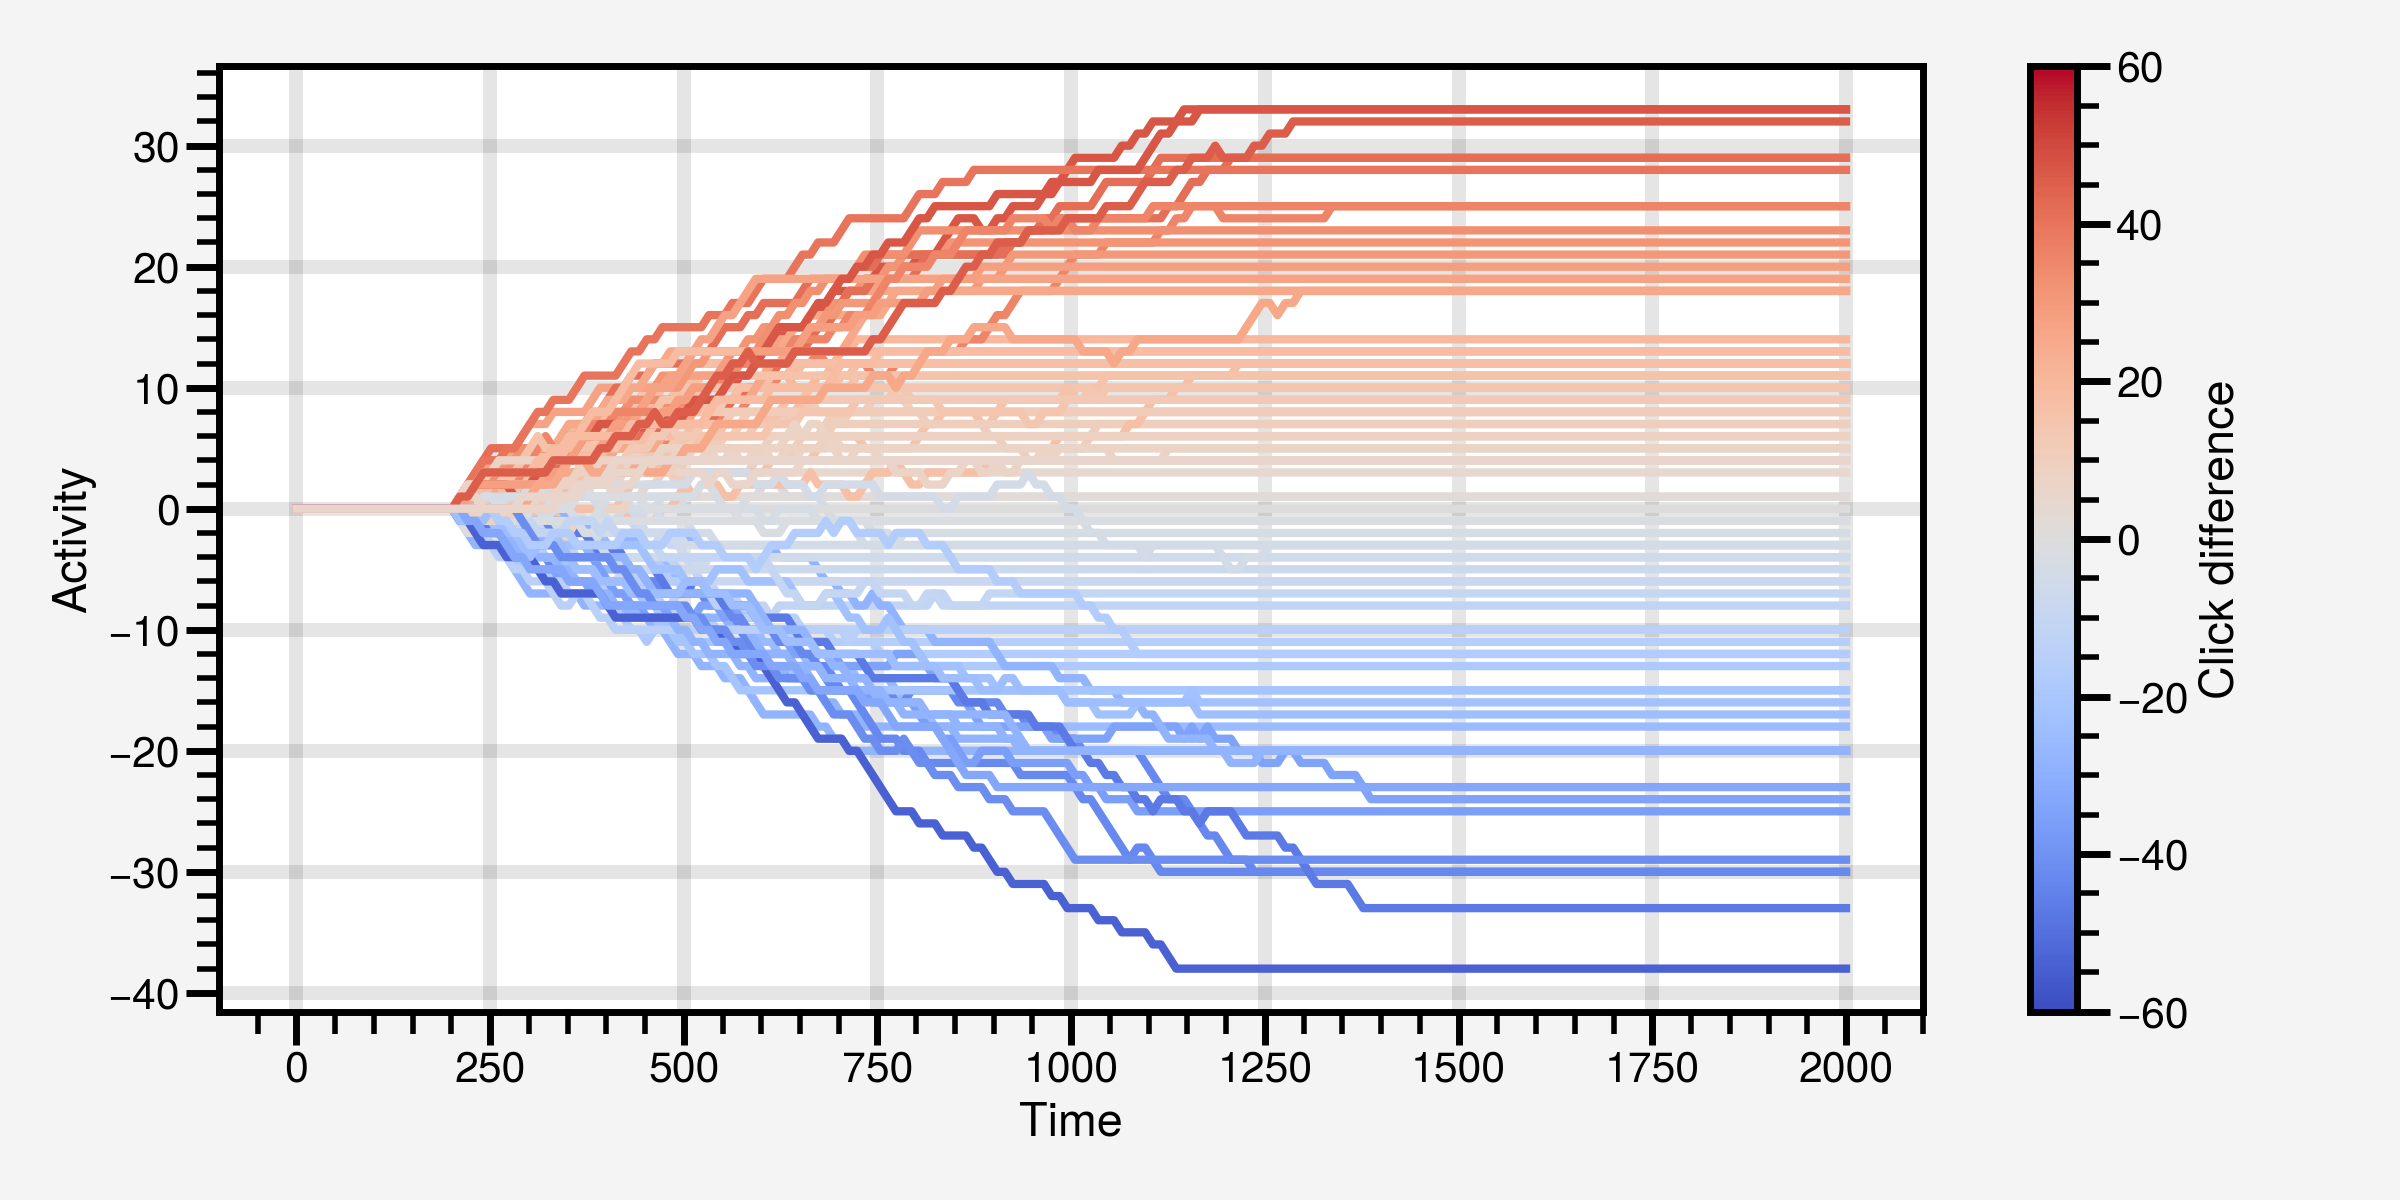

In [52]:
sns.set_context("poster", font_scale = .7, rc={"grid.linewidth": 5})
fig=plt.figure(figsize=(12,6))
ax = plt.subplot(111)
clickdiff = N_clicks[:,0]-N_clicks[:,1]
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(test_x, yhat, output_mask, trial_params)
direction = np.where(N_clicks[:,0]<N_clicks[:,1],-1,np.where(N_clicks[:,0]>N_clicks[:,1],1,0))

norm = mplcolors.CenteredNorm()
# norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
rand_normal_y_norm = norm(clickdiff)
cmap = cm.get_cmap("coolwarm")

colors_list = ['b', 'r']
for trial_i in range(100):
    hs = ax.plot(np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0]), hidden_states[trial_i, :, 0]-hidden_states[trial_i, :, 1], c=cmap(rand_normal_y_norm[trial_i]))
    
    
hs = ax.scatter(0, 0, c=0, s=.0, cmap=cmap, vmin=-60, vmax=60)
plt.colorbar(hs, ax=ax, label='Click difference')
plt.xlabel("Time")
plt.ylabel("Activity")
plt.tight_layout()
plt.savefig(perfect_path + '\\hidden_activity_100.pdf')
plt.savefig(perfect_path + '\\hidden_activity_100.png')

In [13]:
highest_click_count_index = np.argmax(N_clicks, axis=1)
truth = highest_click_count_index[excludeequals]
chosen = np.argmax(np.mean(yhat*y, axis=1), axis = 1)
response_correctness = np.equal(truth, chosen[excludeequals])
accuracy = np.mean(response_correctness)
accuracy

1.0

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\scipy\stats\_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\scipy\stats\_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


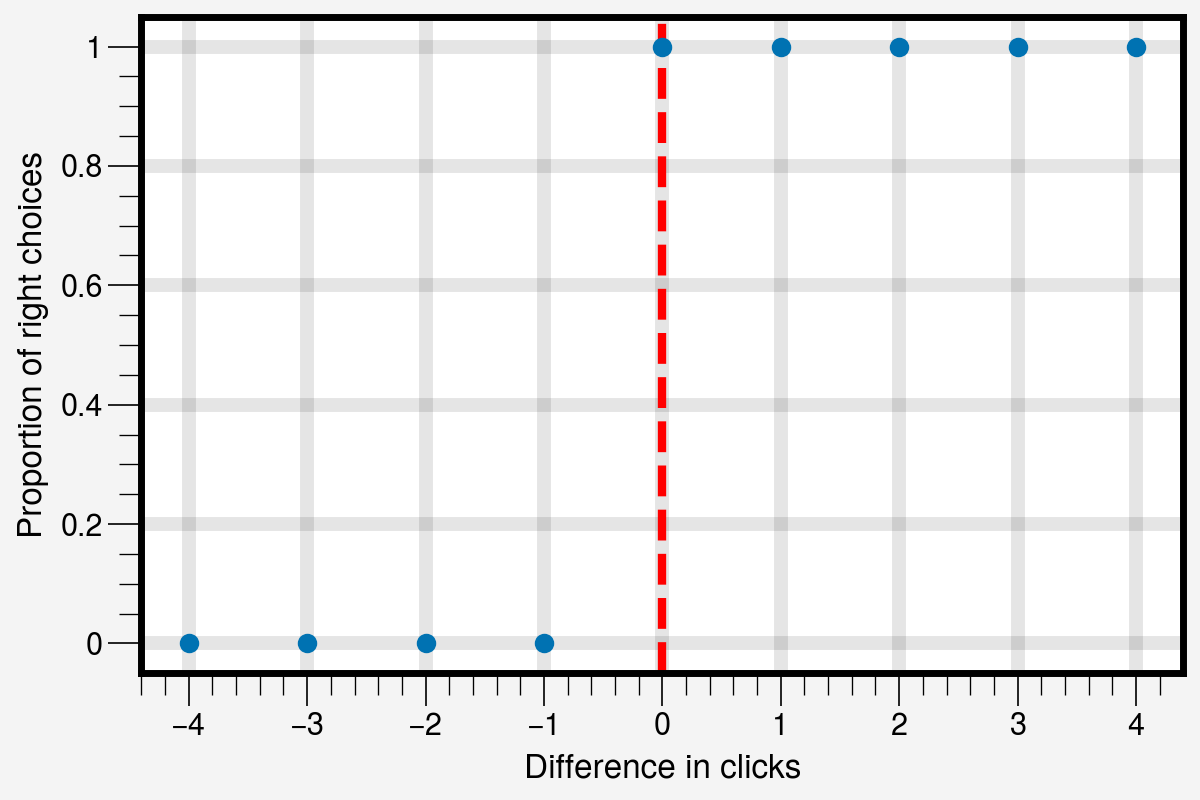

In [14]:
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})
pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
chosen = 1-np.argmax(np.mean(yhat*output_mask, axis=1), axis = 1)
df = pandas.DataFrame({"Choice": chosen, "Difference": N_clicks[:,0]-N_clicks[:,1]})
df = df[abs(df['Difference']) < 5]
ci = np.array([st.t.interval(0.95, len(df['Choice'][df["Difference"] == i])-1, loc=np.mean(df['Choice'][df["Difference"] == i]), scale=st.sem(df['Choice'][df["Difference"] == i])) for i in np.sort(df['Difference'].unique())])
average_perclick = df.groupby("Difference").mean()
std_perclick = df.groupby("Difference").std().to_numpy().squeeze()
ax.errorbar(np.sort(df['Difference'].unique()), average_perclick['Choice'].to_numpy(), yerr=np.abs(ci.T-average_perclick.to_numpy().T),
            fmt='.')
ax.axvline(x = 0, color = 'r', linestyle = '--')

ax.set_xlabel("Difference in clicks")
ax.set_ylabel("Proportion of right choices")
plt.savefig(perfect_path + "/perfect_props_max.pdf")
plt.savefig(perfect_path + "/perfect_props_max.png")

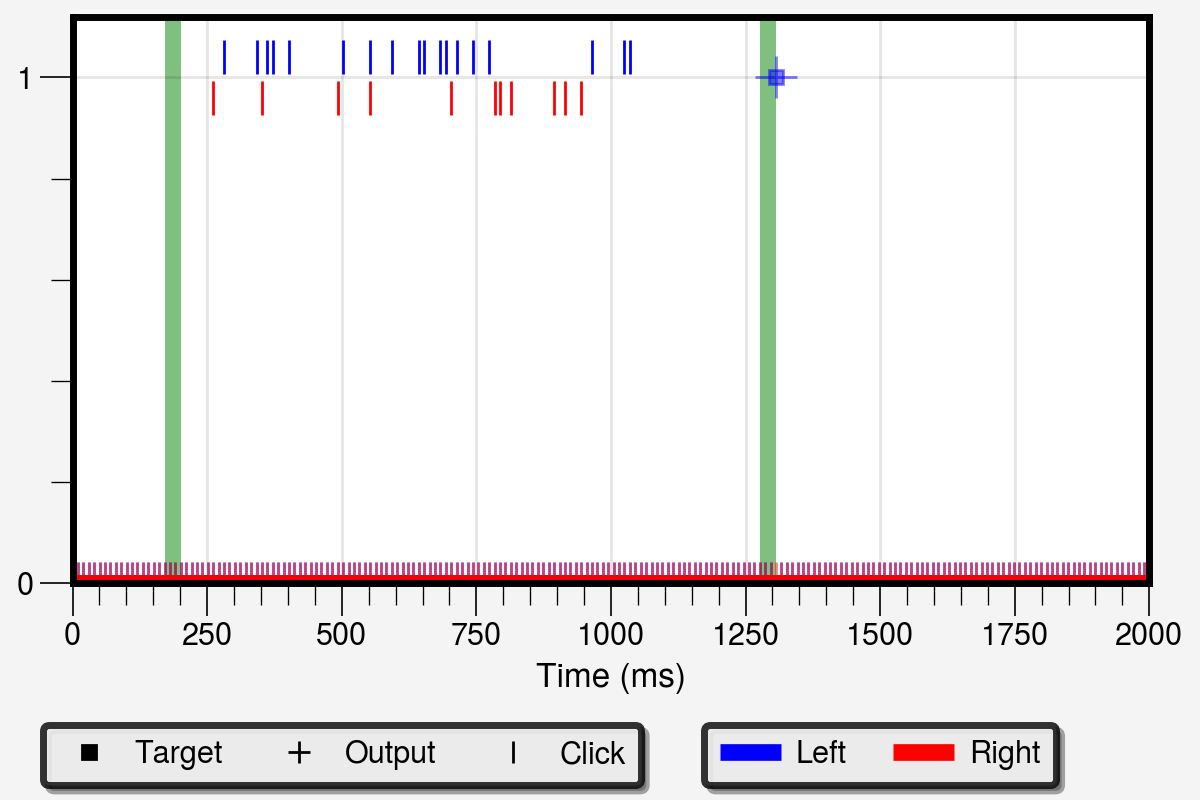

In [16]:
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 1})
plot_trial(0, x=test_x, y=y, yhat=yhat,
       training_kwargs=training_kwargs,
       file_name="correct_trial_example",
       eps = 0.04, padding = 5,
      maxT="full");
plt.savefig(perfect_path + "/perfect_trial_example.pdf")
plt.savefig(perfect_path + "/perfect_trial_example.png")

In [ ]:
wrong_trials = np.where(~response_correctness)[0]

wrong_trials = get_wrong_trials(N_clicks, yhat, output_mask)

wrong_trials = np.where(chosen!=(np.sign(N_clicks[:,0]-N_clicks[:,1])+1)/2.)[0]

wrong_trials

In [ ]:
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 1})
plot_trial(wrong_trials[0], x=test_x, y=y, yhat=yhat,
       training_kwargs=training_kwargs,
       file_name="correct_trial_example",
       eps = 0.04, padding = 5,
      maxT="full");

In [ ]:
sns.histplot((y - yhat).flatten(),palette=['b','r'])

In [ ]:
sns.histplot(BinaryCrossEntropy(y, yhat),palette=['b','r'])

In [ ]:
loss = 0
nonzero_trial_losses = np.zeros((N_test_batch, int(training_kwargs["T"]/training_kwargs['dt'])))
with torch.no_grad():
    end_after = False
    loss_fn = nn.BCEWithLogitsLoss().to(device)
    y_tensor = torch.tensor(y, dtype=torch.float).to(device)
    hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
    yhat_tensor = rnn_model.fc(hidden_states)
    hidden_states = hidden_states.cpu().detach().numpy()
    for trial in range(inputs.shape[0]):
        nonzero_trial_loss = 0
        for t_id in range(inputs.shape[1]):
            nonzero_trial_losses[trial, t_id] = loss_fn.forward(yhat_tensor[trial,t_id,0], y_tensor[trial,t_id,0]) + loss_fn.forward(yhat_tensor[trial,t_id,1], y_tensor[trial,t_id,1])
            # if loss_fn.forward(yhat[trial,t_id,0], y[trial,t_id,0])+loss_fn.forward(yhat[trial,t_id,1], y[trial,t_id,1])>0.:
                # nonzero_trial_loss += loss_fn.forward(yhat[trial,t_id,0], y[trial,t_id,0]) + loss_fn.forward(yhat[trial,t_id,1], y[trial,t_id,1])
                # print(loss_fn.forward(yhat[trial,t_id,0], y[trial,t_id,0]), loss_fn.forward(yhat[trial,t_id,1], y[trial,t_id,1]))
            loss += loss_fn.forward(yhat_tensor[trial,t_id,0], y_tensor[trial,t_id,0])
            loss += loss_fn.forward(yhat_tensor[trial,t_id,1], y_tensor[trial,t_id,1])
    loss /= inputs.shape[1] 
    loss /= inputs.shape[0] 
loss

In [ ]:
nonzero_trial_loss /= inputs.shape[1] 
trial = np.where(np.sum(nonzero_trial_losses, axis=1)>0)[0][0]

In [ ]:
# off_trials = np.unique(np.where(y - yhat > 0)[0])
# for trial in off_trials[:2]:
# print(BinaryCrossEntropy(y[trial,...], yhat[trial,...]))
# plot_trial(trial, x=test_x, y=y, yhat=yhat,
#        training_kwargs=training_kwargs,
#        file_name="correct_trial_example",
#        eps = 0.04, padding = 5,
#       maxT="full")

In [ ]:
trial_i = 151
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 1})
print("Ratio: ", trial_params[trial_i]['ratio']) 
fig = plot_trial(trial_i, x=test_x, y=y, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="correct_trial_example",
           eps = 0.04, padding = 5,
          maxT="full", subplots=111)

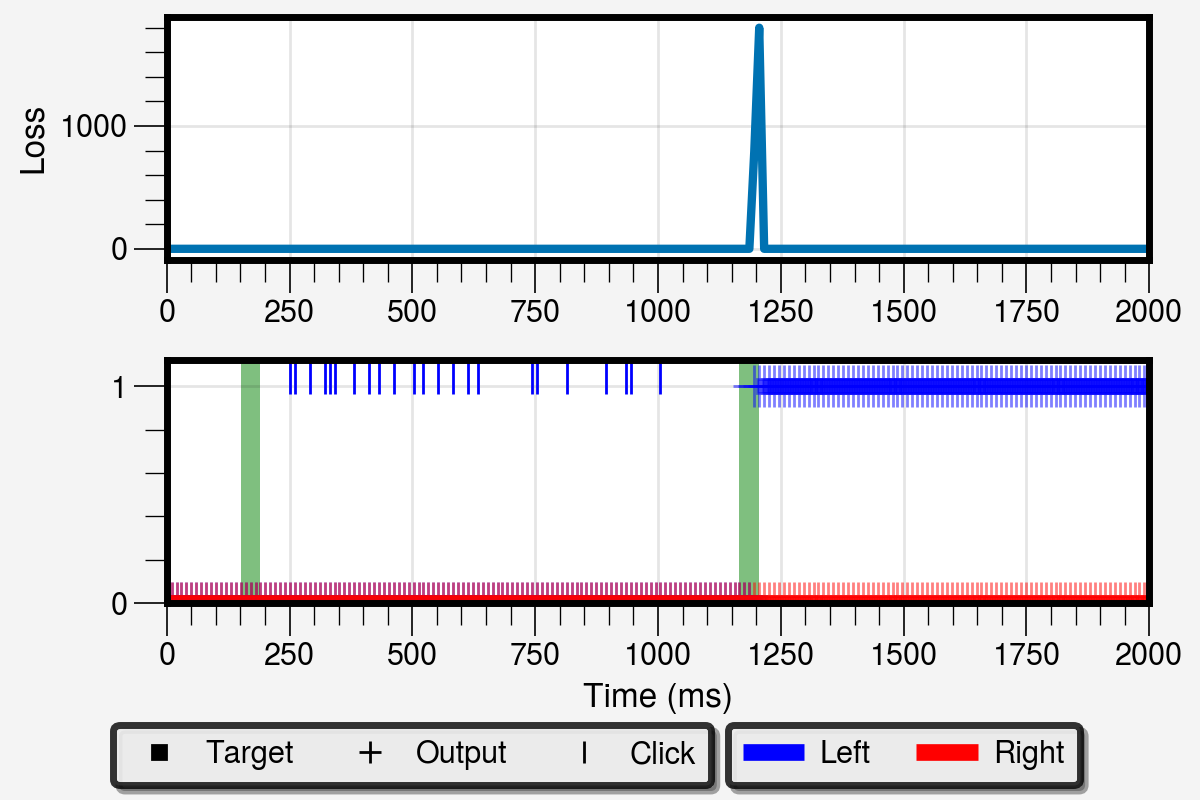

In [146]:
trial_i = trial
x=test_x
y=y
yhat=yhat 
training_kwargs=training_kwargs
file_name="nonzeroloss_trial_example"
eps = 0.04
padding = 5
maxT = "full"
if maxT=="full":
    maxT = y[trial_i,:,0].shape[0]
else:
    maxT = np.max([np.argmax(y[trial_i,:,0]), np.argmax(y[trial_i,:,1])])+padding
times = np.linspace(0, maxT*training_kwargs['dt'], maxT)

fig = pplt.figure(figsize=(6,4), sharex=False, sharey=False)
ax = plt.subplot(211)
plt.plot(times, nonzero_trial_losses[trial_i, :])
# ax.set_xlabel("Time (ms)")
ax.set_ylabel("Loss")
ax = plt.subplot(212)
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

ax.plot(times, eps+np.where(x[trial_i,:maxT,0]>0., x[trial_i,:maxT,0], np.nan), '|', color='b', label = "Clicks Left")
ax.plot(times, y[trial_i,:maxT,0], 'bs', alpha=0.5, markersize=5, label='Target Left')
ax.plot(times, yhat[trial_i,:maxT,0], 'b+', alpha=0.5, markersize=15, label='Output Left')
ax.fill_between(times, 0, 2, where=np.where(x[trial_i,:maxT,2], True, False),
                facecolor='green', alpha=0.5, transform=trans)

ax.plot(times, -eps+np.where(x[trial_i,:maxT,1]>0., x[trial_i,:maxT,1], np.nan), '|', color='r', label = "Clicks Right")
ax.plot(times, y[trial_i,:maxT,1], 'rs', alpha=0.5, markersize=5, label='Target Right')
ax.plot(times, yhat[trial_i,:maxT,1], 'r+', alpha=0.5, markersize=15, label='Output Right')
ax.fill_between(times, 0, 2, where=np.where(x[trial_i,:maxT,3], True, False),
                facecolor='green', alpha=0.5, transform=trans)

ax.set_xlabel("Time (ms)")
ax.set_yticks([0, 1])
ax.set_ylim([0, 1+3*eps])

target = mlines.Line2D([], [], color='k', marker='s', linestyle='None',
                          markersize=5, label='Target')
output = mlines.Line2D([], [], color='k', marker='+', linestyle='None',
                          markersize=8, label='Output')
click = mlines.Line2D([], [], color='k', marker='|', linestyle='None',
                          markersize=8, label='Click')
leg = plt.legend(handles = [target, output, click], 
          loc='upper center', bbox_to_anchor=(0.25, -0.5),
          fancybox=True, shadow=True, ncol=3)

left = mlines.Line2D([], [], color='b', linewidth='6',
                          markersize=5, label='Left')
right = mlines.Line2D([], [], color='r', linewidth='6',
                          markersize=5, label='Right')
ax.add_artist(leg)
plt.legend(handles = [left, right], 
          loc='upper center', bbox_to_anchor=(0.75, -0.5),
          fancybox=True, shadow=True, ncol=3)


plt.savefig(training_kwargs['figures_path'] + "/" + file_name + ".pdf")
plt.savefig(training_kwargs['figures_path'] + "/" + file_name + ".png")

In [147]:
nonzero_trial_losses.shape

(1000, 200)

In [148]:
# trial_i = np.where(~excludeequals)[0][0]

# print("Ratio: ", trial_params[trial_i]['ratio']) 
# pplt.figure(figsize=(6,4))
# ax = plt.subplot(111)

# times = np.linspace(0, training_kwargs['T'], yhat[trial_i, :, 0].shape[0])

# ax.plot(times, np.where(test_x[trial_i,:,0]>0., test_x[trial_i,:,0], np.nan), 'x', color='b')
# ax.plot(times, np.where(test_x[trial_i,:,1]>0., test_x[trial_i,:,1], np.nan), 'x', color='r')
# ax.scatter(times, np.where(test_x[trial_i,:,-1]>0., test_x[trial_i,:,-1], np.nan),  color='k')

# ax.plot(times, y[trial_i,:,0], 'b-', label='Target 0')
# ax.plot(times, y[trial_i,:,1], 'r-', label='Target 1')
# ax.plot(times, yhat[trial_i,:,0], 'b--', label='Network output 0')
# ax.plot(times, yhat[trial_i,:,1], 'r--', label='Network output 1')

# ax.set_xlabel("Time (ms)")
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=1)

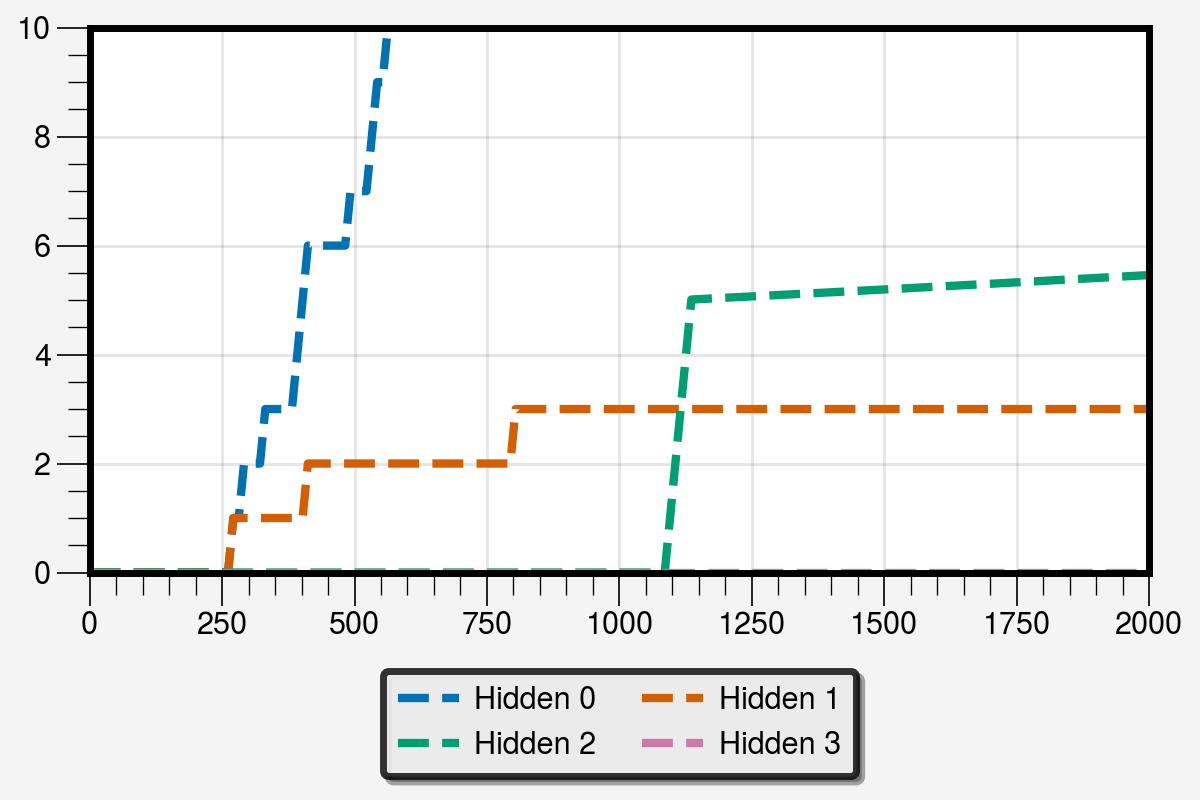

In [285]:
pplt.figure(figsize=(6,4))
ax = plt.subplot(111)

trial_i = 0 # wrong_trials[0]
times = np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0])
for hidden_i in range(hidden_states.shape[-1]):
    ax.plot(times, hidden_states[trial_i, :, hidden_i], '--', label='Hidden %d'%hidden_i)
# plt.plot(times, test_x[trial_i,:,0], 'xb', label='Input 0')
# plt.plot(times, test_x[trial_i,:,1], 'xr', label='Input 1')

# plt.plot(times, yhat[trial_i,:,0], '-ob', label='Output 0')
# plt.plot(times, yhat[trial_i,:,1], '-or', label='Output 1')

# plt.plot(times, y[trial_i,:,0], 'ob')
# plt.plot(times, y[trial_i,:,1], 'or')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18),
          fancybox=True, shadow=True, ncol=2)
ax.set_ylim([0,10]);
# ax.legend(loc='center right'); # Put a legend to the right of the current axis
# plt.savefig(perfect_path + '\\hiddenact_example_ratio%s.pdf'%(trial_params[trial_i]['ratio']))
# plt.savefig(perfect_path + '\\hiddenact_example_ratio%s.png'%(trial_params[trial_i]['ratio']))